In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from files.Simulation import Simulation
from files.Source import Source
from files.Observer import Observer
from plot.Trajectory import Trajectory

## Simulation setup

#### Parameters

In [130]:
nr_particles = 10**2
nr_steps = 10**5
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
observer_substeps = np.array([False, False, True]) # observe only steps (no substeps)
mfp = [3.75*10**13/4.0, 3.75*10**13/4.0, 7.2*10**13]  # [m]
delta_rho_div_phi = 1 # (delta_r_rho / delta_r_phi)
gyro_radius = 10**11 # [m]; 1pc
all_steps = False

In [131]:
sim = Simulation()

source = Source(gyro_radius, mfp, source_pos, nr_particles)
sim.add_source(source)

observer = Observer(observer_substeps, all_steps)
sim.add_observer(observer)

%time sim.run_simulation(nr_steps)
sim.save_data('data')

start simulation
source
observer
CPU times: user 17.9 s, sys: 255 ms, total: 18.1 s
Wall time: 18.2 s


## Analyze statistics


In [197]:
class Statistics():
    def __init__(self, df, dimensions):
        print('init statistics plotting class')
        self.df = df
        self.dimensions = dimensions
    
    def plot_distribution(self, axis, step, bins, file_name):
        # if user wants to plot the laast step, deduce the correct step number of the last step
        if step == -1:
            # get last step
            step = max(df['i'].tolist())
        # filter data according to the selected step
        df_i = self.df[self.df['i'] == step]
        
        # fit a normal distribution to the data:
        mu, std = norm.fit(df_i[axis])
        
        plt.figure(figsize=(4,4))
        # compute the factor between the original and normalized hists
        x_norm, b, p = plt.hist(df_i[axis], bins, density=True)
        x_original, b, p = plt.hist(df_i[axis], bins)
        scale = max(x_original)/max(x_norm)
    
        # plot the PDF scaled with the factor between the original and normalized hists
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)*scale
        plt.plot(x, p, 'k', linewidth=2)
        
        plt.xlabel(axis + ' [m]')
        plt.ylabel('# particles')
        label = "mu = %.2f,  std = %.2f" % (mu, std)
        #plt.legend()
        if file_name is not None:
            plt.tight_layout()
            plt.savefig(file_name)
        plt.show()
        
    def plot_diffusion_coefficients(self):
        nr_particle = len(list(map(int, (set(self.df['id'])))))
        df = self.df.sort_values('d')
        x = df['x'].values
        y = df['y'].values
        z = df['z'].values
        t = df['d'].values
        times = []
        kappa_xx = []
        kappa_yy = []
        kappa_perp = []
        kappa_zz = []
        for j in range(1, int(len(x)/nr_particles)):
            t_j = t[j*nr_particles]
            kappa_xx_current = 0
            kappa_yy_current = 0
            kappa_zz_current = 0
            for i in range(nr_particles):
                x_i = x[j*nr_particles+i]
                y_i = y[j*nr_particles+i]
                z_i = z[j*nr_particles+i]
                kappa_xx_current = kappa_xx_current + x_i**2
                kappa_yy_current = kappa_yy_current + y_i**2
                kappa_zz_current = kappa_zz_current + z_i**2
            kappa_xx.append(kappa_xx_current/(2*t_j))
            kappa_yy.append(kappa_yy_current/(2*t_j))
            kappa_perp.append((kappa_xx_current+kappa_yy_current)/(4*t_j))
            kappa_zz.append(kappa_zz_current/(2*t_j))
            times.append(t_j)
        plt.figure(figsize=(4,4))
        plt.plot(times, kappa_xx, label='$\kappa_{xx}$')
        plt.plot(times, kappa_yy, label='$\kappa_{yy}$')
        plt.plot(times, kappa_perp, label='$\kappa_\perp$')
        plt.plot(times, kappa_zz, label='$\kappa_\parallel$')
        plt.loglog()
        plt.legend()
        plt.show()
        
        d = {'kappa_perp':kappa_perp,'kappa_para':kappa_zz}
        return pd.DataFrame(d)

In [198]:
#from plot.Trajectory import Trajectory

df = pd.read_pickle("data.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
dimensions = 3
sta = Statistics(df_time_evolution_observer, dimensions)
tra = Trajectory(df_time_evolution_observer, dimensions)
particle_ids = tra.get_particle_ids()

init statistics plotting class
init trajectory plotting class


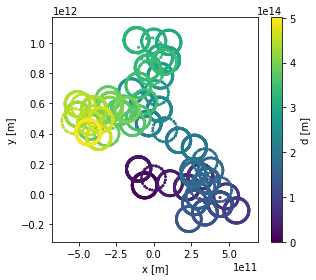

In [199]:
nr_steps = 3*10**4
tra.plot_trajectory('x', 'y', 'd', particle_ids[0], nr_steps, None)

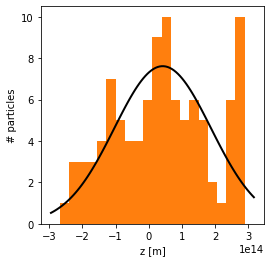

In [200]:
bins = 20
file_name = None
sta.plot_distribution('z', -1, bins, file_name)

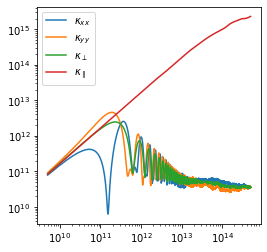

In [201]:
df_kappas = sta.plot_diffusion_coefficients()

In [129]:
df_kappas

,kappa_perp,kappa_para
0,2.562500e+11,2.500000e+11
1,5.121798e+11,5.000000e+11
2,7.674695e+11,7.500000e+11
3,1.021800e+12,9.999999e+11
4,1.274855e+12,1.250000e+12
...,...,...
3174,1.114079e+11,4.129418e+15
3175,1.098528e+11,4.129999e+15
3176,1.088052e+11,4.130581e+15
3177,1.084883e+11,4.131165e+15
